## ODIAC Fossil Fuel CO₂ Emissions 

Monthly, global 1 km resolution dataset of fossil fuel carbon dioxide emissions, version 2022

Authors: Siddharth Chaudhary, Vishal Gaur

Published: 29 June 2023


## Running this notebook

You can launch this notebook using mybinder by clicking the button below.

<a href="https://mybinder.org/v2/gh/NASA-IMPACT/GHGC_docs/HEAD?labpath=user_data_notebooks/fossil_fuel_co2_emissions.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the ODIAC fossil fuel CO₂ emissions data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

The Open-source Data Inventory for Anthropogenic CO₂ (ODIAC) data product is a monthly high-resolution global data product of modeled fossil fuel carbon dioxide (CO₂) emissions. A complex model incorporates and combines space-based nighttime light data and individual power plant emission/location profiles to estimate the global spatial extent of CO₂ emissions on a 1 km x 1 km grid. Detailed variations are observable in urban regions where emissions are the most intense. ODIAC CO₂ emission data is widely used by the international research community for applications such as measuring CO₂ flux inversions, estimating urban emissions, and observing system design experiments. Formed in 2009 by Dr. Tomohiro Oda, the ODIAC team is now supported by NASA Goddard Space Flight Center, the NASA Carbon Monitoring System program, the NASA Orbiting Carbon Observatory mission, and the National Institute for Environmental Studies (NIES) GOSAT project. The GHG Center displays the ODIAC 2022 version containing monthly data from January 2000 to December 2022 that replaces all previous versions.

# Installing the Required Libraries
Please run the next cell to install all the required libraries to run the notebook.

## Querying the STAC API

In [1]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://dev.ghg.center/api/stac"
RASTER_API_URL = "https://dev.ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.

# Name of the collection for ODIAC dataset. 
collection_name = "odiac-fossil-fuel-co2-emissions-2022"

In [3]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'odiac-fossil-fuel-co2-emissions-2022',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/odiac-fossil-fuel-co2-emissions-2022/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/odiac-fossil-fuel-co2-emissions-2022'}],
 'title': 'ODIAC Fossil Fuel CO₂ Emissions Version 2022',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2000-01-01 00:00:00+00',
     '2021-12-01 00:00:00+00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': [{'url': 'https

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2000 to December 2021. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is monthly.

In [4]:
# Check the total number of items available
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=300").json()["features"]
print(f"Found {len(items)} items")

Found 264 items


In [5]:
# Examining the first item in the collection
items[0]

{'id': 'odiac-fossil-fuel-co2-emissions-2022-202112',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/odiac-fossil-fuel-co2-emissions-2022'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/odiac-fossil-fuel-co2-emissions-2022'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/odiac-fossil-fuel-co2-emissions-2022/items/odiac-fossil-fuel-co2-emissions-2022-202112'}],
 'assets': {'co2-emissions': {'href': 's3://ghgc-data-store-dev/ODIAC_geotiffs_COGs/odiac2022_1km_excl_intl_202112.tif',
   'type': 'image/tiff; applicatio

Since there are 22 years between 2000 and 2021 with 12 months per year, we expect 264 records in total.

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in CO₂ Levels Using the Raster API

In this notebook, we will explore the impacts of fossil fuel emissions and by examining changes over time in urban regions. We will visualize the outputs on a map using `folium.`

In [7]:
# To access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:7]: item for item in items} 

In [12]:
rescale_values = {"max":items[list(items.keys())[0]]["assets"]["co2-emissions"]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"]["co2-emissions"]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for December 2001 and again for December 2021, so that we can visualize each event independently.

In [9]:
color_map = "rainbow" # select the color ramp from matplotlib library.
december_2001_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2001-12']['collection']}&item={items['2001-12']['id']}"
    "&assets=co2-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
december_2001_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=odiac-fossil-fuel-co2-emissions-2022&item=odiac-fossil-fuel-co2-emissions-2022-200112&assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-138.71914672851562%2C2497.01904296875'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [10]:
december_2021_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2021-12']['collection']}&item={items['2021-12']['id']}"
    "&assets=co2-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
december_2021_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=odiac-fossil-fuel-co2-emissions-2022&item=odiac-fossil-fuel-co2-emissions-2022-202112&assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-138.71914672851562%2C2497.01904296875'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualizing CO₂ Emissions


In [10]:
# We will import folium to map and folium.plugins to allow side-by-side mapping
import folium
import folium.plugins

# Set initial zoom and center of map for CO₂ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# December 2001
map_layer_2001 = TileLayer(
    tiles=december_2001_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2001.add_to(map_.m1)

# December 2021
map_layer_2021 = TileLayer(
    tiles=december_2021_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2021.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [11]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [12]:
# We will plug in the coordinates for a location inside the the polygon and a zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [13]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]
print(f"Found {len(items)} items")

Found 264 items


In [14]:
# Explore the first item
items[0]

{'id': 'odiac-fossil-fuel-co2-emissions-2022-202112',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/odiac-fossil-fuel-co2-emissions-2022'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/odiac-fossil-fuel-co2-emissions-2022'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/odiac-fossil-fuel-co2-emissions-2022/items/odiac-fossil-fuel-co2-emissions-2022-202112'}],
 'assets': {'co2-emissions': {'href': 's3://ghgc-data-store-dev/ODIAC_geotiffs_COGs/odiac2022_1km_excl_intl_202112.tif',
   'type': 'image/tiff; applicatio

In [15]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"]["co2-emissions"]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"],
    }

With the function above, we can generate the statistics for the area of interest.

In [16]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 6.37 s, sys: 765 ms, total: 7.13 s
Wall time: 5min 22s


In [17]:
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 404594.21875,
   'mean': 12.58496736225329,
   'count': 466944.0,
   'sum': 5876475.0,
   'std': 1022.6532606034702,
   'median': 0.0,
   'majority': 0.0,
   'minority': 0.8238743543624878,
   'unique': 145410.0,
   'histogram': [[466931.0, 7.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0],
    [0.0,
     40459.421875,
     80918.84375,
     121378.265625,
     161837.6875,
     202297.109375,
     242756.53125,
     283215.9375,
     323675.375,
     364134.8125,
     404594.21875]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 466944.0,
   'percentile_98': 120.89053268432629,
   'percentile_2': 0.0}},
 'start_datetime': '2021-12-01T00:00:00+00:00'}

In [18]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_98,percentile_2,date
0,2021-12-01T00:00:00+00:00,0.0,404594.21875,12.584967,466944.0,5876475.0,1022.653261,0.0,0.0,0.823874,145410.0,"[[466931.0, 7.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,...",100.0,0.0,466944.0,120.890533,0.0,2021-12-01 00:00:00+00:00
1,2021-11-01T00:00:00+00:00,0.0,379500.71875,11.807978,466944.0,5513664.5,959.227452,0.0,0.0,0.773158,145397.0,"[[466931.0, 7.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,...",100.0,0.0,466944.0,113.458157,0.0,2021-11-01 00:00:00+00:00
2,2021-10-01T00:00:00+00:00,0.0,365564.12500,11.382001,466944.0,5314757.0,924.002397,0.0,0.0,0.745633,145400.0,"[[466931.0, 7.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,...",100.0,0.0,466944.0,109.419010,0.0,2021-10-01 00:00:00+00:00
3,2021-09-01T00:00:00+00:00,0.0,369532.53125,11.499615,466944.0,5369676.0,934.032133,0.0,0.0,0.753175,145405.0,"[[466931.0, 7.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,...",100.0,0.0,466944.0,110.491998,0.0,2021-09-01 00:00:00+00:00
4,2021-08-01T00:00:00+00:00,0.0,412252.34375,12.818087,466944.0,5985329.0,1042.009448,0.0,0.0,0.839226,145410.0,"[[466931.0, 7.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,...",100.0,0.0,466944.0,122.994610,0.0,2021-08-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the ODIAC fossil fuel emission time series (January 2000 -December 2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CO₂ emission Values for Texas, Dallas (2000-2021)')

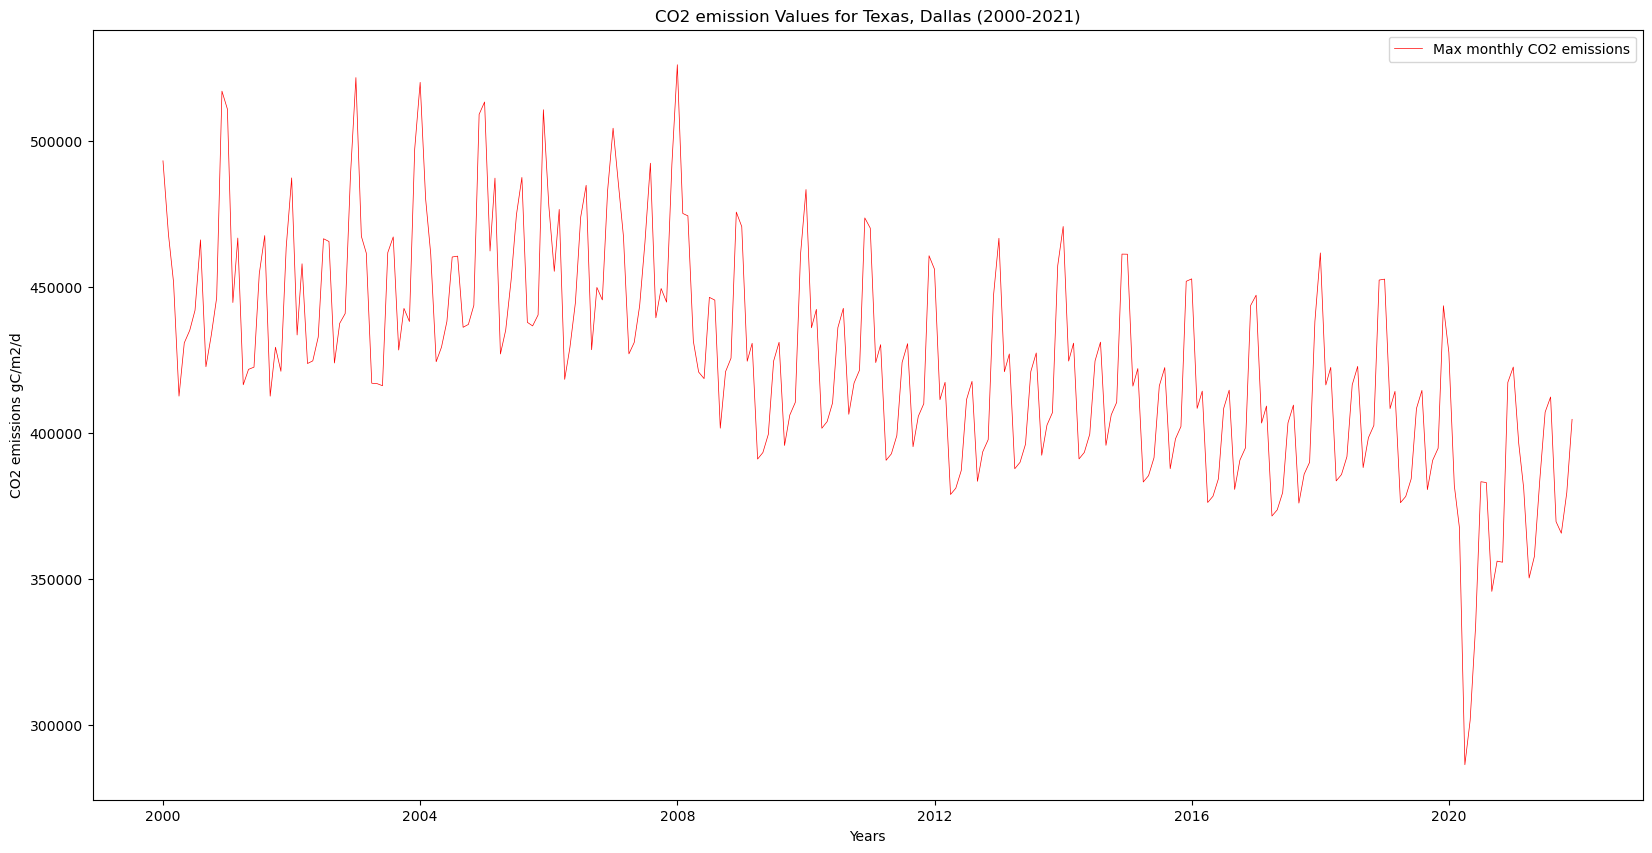

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CO2 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO2 emissions tons C/month")
plt.title("CO2 emission Values for Texas, Dallas (2000-2021)")

In [20]:
print(items[2]["properties"]["start_datetime"])

2021-10-01T00:00:00+00:00


In [21]:
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    "&assets=co2-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=odiac-fossil-fuel-co2-emissions-2022&item=odiac-fossil-fuel-co2-emissions-2022-202110&assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-10%2C300'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [23]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=8,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 0.5
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for ODIAC fossil fuel CO₂ emissions.